# Bayesian SIR

Antonio Feltrin, Giosuè Sardo Infirri, Riccardo Tancredi, Simone Toso


## Scaletta
 - MCMC con un solo parametro

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.special import gamma as gammafunc
from scipy.stats import gamma as gammadist
from tqdm.notebook import tqdm

## Data generation

In [2]:
# Parameter initialization
N = 1_000_000
T = 101
I0 = 50

betas = 25*[0.3]+25*[.4]+25*[.25]+26*[.2]
gammas = 25*[0.05]+25*[.15]+25*[.2]+26*[.25]

# Simulation
initial_conf = np.array([N-I0, I0, 0])

configurations = np.zeros([T, 3])
configurations[0, :] = initial_conf
for tt in range(1, T):
    beta_true = betas[tt]
    gamma_true = gammas[tt]
    
    delta_I = npr.binomial(configurations[tt-1][0],
                           1 - np.exp(-beta_true*configurations[tt-1][1]/N))

    delta_R = npr.binomial(configurations[tt-1][1],
                           gamma_true)
    configurations[tt][0] = configurations[tt-1][0] - delta_I
    configurations[tt][1] = configurations[tt-1][1] + delta_I - delta_R
    configurations[tt][2] = configurations[tt-1][2] + delta_R

Text(0.5, 1.0, 'Simulated data with varying parameters')

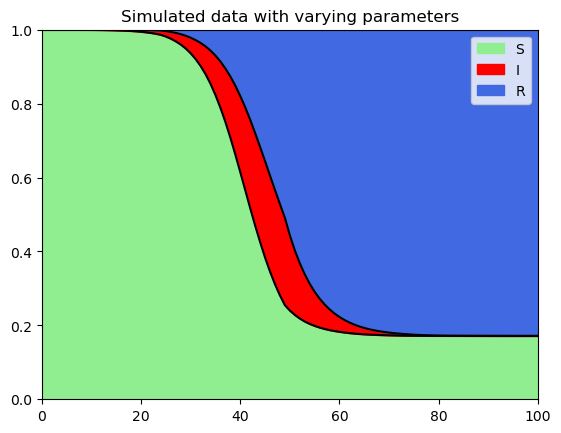

In [3]:
xs = np.arange(0, T)
ss = configurations[:, 0] / N
ii = configurations[:, 1]/N + ss
rr = configurations[:, 2]/N + ii

plt.plot(ss, c = "black")
plt.plot(ii, c = "black")
plt.plot(rr, c = "black")
plt.ylim([0, 1])

plt.fill_between(xs, 0, ss, label = "S", color = "lightgreen")
plt.fill_between(xs, ss, ii, label = "I", color = "red")
plt.fill_between(xs, ii, rr, label = "R", color = "royalblue")

plt.xlim([0, T-1])
plt.legend()
plt.title("Simulated data with varying parameters")

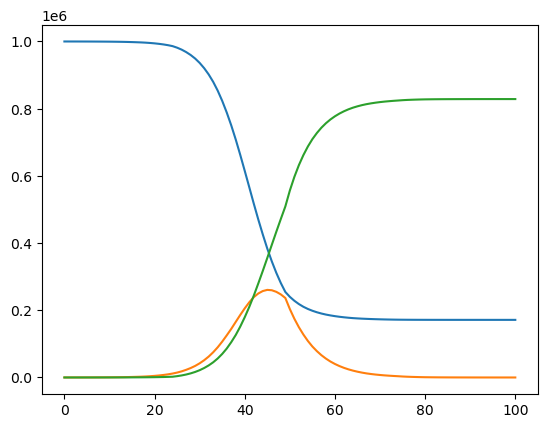

In [4]:
plt.plot(configurations[:, 0])
plt.plot(configurations[:, 1])
plt.plot(configurations[:, 2])

# MCMC functions definition


In [5]:
def mylog(x):
    try:
        x = np.array(x)
        mask = x > 1e-323
        output = np.zeros(len(x))
        output[mask] = np.log(x[mask])
        output[~mask] = -744
        return output
    except:
        return np.log(x) if x > 0 else -744

### Delta update

In [6]:
def conditional_betagamma_old(delta, beta, gamma):
    K = np.sum(delta).astype(int)
    eta = np.cumsum(delta)
    total = 0
    for ii in range(K):
        indic = eta == ii
        total += 2*mylog(gammafunc(0.1 + np.sum(indic)))
        total -= mylog(0.1 + np.sum(beta*(indic)))*(0.1 + np.sum(indic))
        total -= mylog(0.1 - np.sum(mylog(gamma)*(indic)))*(0.1 + np.sum(indic))
    return total

def conditional_betagamma(delta, beta, gamma):
    K = np.sum(delta).astype(int)
    eta = np.cumsum(delta)
    total = 0
    for ii in range(K):
        indic = eta == ii
        total = total + 0.2*np.log(0.1) - 2*np.log(gammafunc(0.1))
        total = total + 2*mylog(gammafunc(0.1 + np.sum(indic))) - np.sum(indic*mylog(gamma))
        total = total - (0.1+np.sum(indic))*(mylog(.1 + np.sum(indic*beta)) + mylog(0.1 - np.sum(indic*mylog(gamma))))
    return total

def JJ(delta_proposed, delta_now, T):
    
    sum_proposed = np.sum(delta_proposed).astype(int)
    sum_now = np.sum(delta_now).astype(int)
    
    if sum_proposed == sum_now:
        return 1
    elif [sum_proposed, sum_now] == [1, 2] or [sum_proposed, sum_now] == [T, T-1]:
        return 3/(T-1)
    elif [sum_proposed, sum_now] == [2, 1] or [sum_proposed, sum_now] == [T-1, T]:
        return (T-1)/3
    elif sum_proposed < sum_now:
        return (sum_now - 1)/(T-sum_proposed)
    else:
        return (T- sum_now) / (sum_proposed - 1)
    
def update_delta(delta_proposed, delta_now, beta_now, gamma_now, p, T):
    #Step 1: evaluate first term pi/pi
    difference = np.sum(delta_proposed - delta_now)
    first_term = difference*mylog(p/(1-p))
    
    #Step 2: evaluate second term:
    second_term = conditional_betagamma(delta_proposed, beta_now, gamma_now)
    second_term -= conditional_betagamma(delta_now, beta_now, gamma_now)
    
    #Step 3: evaluate third term
    third_term = mylog(JJ(delta_proposed, delta_now, T))
    
    log_m = first_term + second_term + third_term
        
    probability = min(0, log_m)
    
        
    eps = np.log(npr.uniform()) 
    if eps < probability:
        return delta_proposed
    else:
        return delta_now
    
def propose_delta(delta_now, T):
    delta = delta_now.copy()
    K = np.sum(delta).astype(int)
    if K == 1:
        probs = np.array([1,0,0])
    elif K==T:
        probs = np.array([0,1,0])
    else:
        probs = np.array([1,1,1])/3
        
    choice = npr.choice([0,1,2], p = probs)
    
    if choice == 0: #add
        index = npr.choice(np.where(delta_now == 0)[0])
        delta[index] += 1
    elif choice == 1: #delete
        index = npr.choice(np.where(delta_now[1:] == 1)[0]) + 1
        delta[index] -= 1
    else: #swap
        candidates = np.where((delta_now[1:T-1] - delta_now[2:T]) != 0)[0] + 1
        index_0 = npr.choice(candidates)
        delta[index_0] = 1 - delta[index_0]
        delta[index_0+1] = 1 - delta[index_0+1]

    
    return delta  

### b and r update

In [7]:
def update_b(delta_now, beta_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    b_next = np.zeros(K)
    for kk in range(K):
        b_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1+np.sum(beta_now*(eta==kk))))
    return b_next

def update_r(delta_now, gamma_now):
    eta = np.cumsum(delta_now)
    K = np.sum(delta_now)
    r_next = np.zeros(K)
    for kk in range(K):
        r_next[kk] = npr.gamma(0.1 + np.sum((eta==kk)), 1/(0.1 + np.sum(-mylog(gamma_now)*(eta==kk))))

    return r_next

### Update beta and gamma

In [8]:
# For each beta find a sample from posterior
# def update_beta(S, I, N, T, b): #cool beta distribution trick
#     new_betas = np.zeros(T)
#     for tt in range(T):
#         C = I[tt]/N
#         D = -S[tt+1]+S[tt]
#         A = C*(S[tt]-D)+b[tt]
#         if C > 1e-4:
#             y = npr.beta(a = A/C, b = D+1)
#             new_betas[tt] = -1/C*np.log(y)
#         else:
#             y = npr.exponential(scale=1/(b[tt] + I[tt]*S[tt]/N))
#             new_betas[tt] = y
        
#     return new_betas

def update_beta(S, I, N, T, b): 
    new_betas = np.zeros(T)
    for tt in range(T):
        delta_I = S[tt] - S[tt+1]
        P_t = I[tt]/N
        new_betas[tt] = npr.gamma(delta_I + 1, 1./(S[tt]-delta_I + b[tt]/P_t))/P_t
    return new_betas

def update_gamma(I, R, N, T, r):
    new_gammas = np.zeros(T)
    for tt in range(T):
        delta_R = R[tt+1]-R[tt]
        new_gammas[tt] = npr.beta(delta_R + r[tt], I[tt]-delta_R+1)
    return new_gammas

# Let's try a full run

In [9]:
n_steps = 25_000

p = 0.01
T = T - 1

burnin = 5_000
thin = 10

betas_run = np.zeros([T, n_steps])
gammas_run = np.zeros([T, n_steps])
bs_run = np.zeros([T, n_steps])
rs_run = np.zeros([T, n_steps])
deltas_run = np.zeros([T, n_steps])


# Initialize parameters
delta_0 = (npr.uniform(size = T) < p).astype(int)
delta_0[0] = 1

KK = np.sum(delta_0)
eta = np.cumsum(delta_0)
rb = npr.gamma(shape = .1, scale = 10, size = (2,KK))
r_0 = rb[0]
b_0 = rb[1]

r_0 = r_0[eta-1]
b_0 = b_0[eta-1]

beta_0 = npr.exponential(1/b_0)
gamma_0 = npr.beta(r_0, 1)

delta = delta_0.copy()
beta = beta_0.copy()
gamma = gamma_0.copy()
r = r_0.copy()
b = b_0.copy()


for step in tqdm(list(range(n_steps)), total=n_steps, desc='Buffering...', colour='green'):
    
    delta_new = propose_delta(delta, T)
    delta = update_delta(delta_new, delta, beta, gamma, p, T)

    b = update_b(delta, beta)
    r = update_r(delta, gamma)

    eta = np.cumsum(delta)
    b = b[eta-1]
    r = r[eta-1]
    
    beta = update_beta(configurations[:,0], configurations[:,1], N, T, b)
    gamma = update_gamma(configurations[:,1], configurations[:,2], N, T, r)
    
    if step >= burnin:
        betas_run[:, step] = beta
        gammas_run[:,step] = gamma
        deltas_run[:,step] = delta
        bs_run[:,step] = b
        rs_run[:,step] = r

Buffering...:   0%|          | 0/25000 [00:00<?, ?it/s]

## Bayesian estimators

In [10]:
# Keep columns which are not empty

deltas_samples = deltas_run[:, burnin::thin]
bs_samples = bs_run[:, burnin::thin]
rs_samples = rs_run[:, burnin::thin]
betas_samples = betas_run[:, burnin::thin]
gammas_samples = gammas_run[:, burnin::thin]

In [11]:
#Every row is a timestep
beta_mean = np.mean(betas_samples, axis = 1)
beta_mean

array([0.47101682, 0.29388669, 0.29319807, 0.37370451, 0.29127635,
       0.31177919, 0.30249995, 0.27952588, 0.25863686, 0.27681605,
       0.34978671, 0.28496465, 0.30311856, 0.30256198, 0.32958713,
       0.29098818, 0.27251876, 0.30100594, 0.31600352, 0.3086481 ,
       0.31285108, 0.30164907, 0.29707239, 0.30187529, 0.40086611,
       0.40574528, 0.41001169, 0.39918969, 0.39876119, 0.40315497,
       0.40372958, 0.40156235, 0.40353983, 0.40817701, 0.41120038,
       0.4101858 , 0.40685754, 0.41315508, 0.4165789 , 0.4172993 ,
       0.4156163 , 0.4220706 , 0.41998789, 0.4195437 , 0.42652259,
       0.42138872, 0.42325545, 0.42353239, 0.42127004, 0.25557296,
       0.25159538, 0.25545951, 0.25700373, 0.25035653, 0.24871429,
       0.25051835, 0.25137822, 0.25027258, 0.24233418, 0.25247106,
       0.25515617, 0.25477089, 0.26621837, 0.25867229, 0.24260714,
       0.25010803, 0.23398871, 0.25186271, 0.25394679, 0.26540834,
       0.26748146, 0.26504752, 0.27256752, 0.24997099, 0.19011

In [12]:
beta = np.mean(betas_samples, axis = 1)
beta_mean.reshape(4, 25).mean(axis=1)

array([0.31303351, 0.40631637, 0.25152107, 0.25325388])

In [13]:
gamma = np.mean(gammas_samples, axis = 1)
gamma.reshape(4, 25).mean(axis=1)
#plt.plot(gamma)

array([0.05666018, 0.15219273, 0.20286425, 0.29262755])

In [14]:
gamma

array([0.05412494, 0.05286116, 0.05401034, 0.06273451, 0.08249063,
       0.03425609, 0.04886748, 0.07188476, 0.05381745, 0.05906644,
       0.0773625 , 0.03966855, 0.05775422, 0.04756422, 0.04966453,
       0.04825177, 0.04396654, 0.04330262, 0.04486751, 0.04940328,
       0.04929998, 0.04571999, 0.05198658, 0.04773196, 0.14584641,
       0.14659339, 0.14875288, 0.15033465, 0.15163521, 0.15191447,
       0.15312351, 0.15120091, 0.14944788, 0.15085453, 0.15061266,
       0.14984197, 0.15155171, 0.14804892, 0.15097398, 0.15046651,
       0.14847999, 0.14995728, 0.15170599, 0.14959132, 0.15015756,
       0.14973777, 0.15010493, 0.1490658 , 0.15041176, 0.2002526 ,
       0.19919664, 0.19963889, 0.19993824, 0.20088463, 0.20153259,
       0.19875368, 0.20136392, 0.19942903, 0.20019566, 0.19960177,
       0.20123025, 0.20122345, 0.20350966, 0.20250905, 0.19922159,
       0.20222674, 0.20095615, 0.19598085, 0.19804302, 0.19820328,
       0.20101114, 0.19351951, 0.20403514, 0.20999489, 0.25940

In [15]:
# deltas_run[:, (np.sum(deltas_run, axis = 0)) > 3]#[:, -2]

In [16]:
deltas_samples#.shape

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [17]:
etas_samples = np.cumsum(deltas_samples, axis=0)

In [18]:
etas_samples

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [2., 2., 2., ..., 2., 1., 1.],
       [2., 2., 2., ..., 2., 1., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

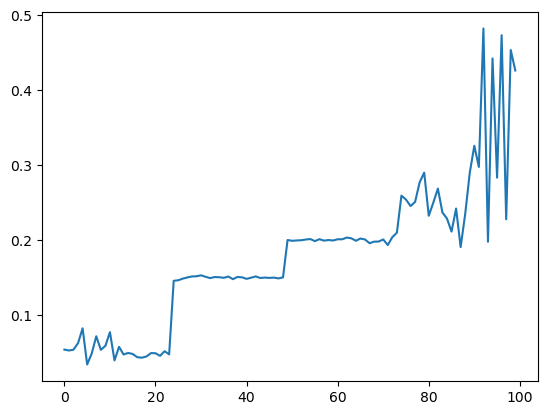

In [19]:
plt.plot(gamma);

### Veloce istogramma dei delta giusto per controllare che abbiano senso dove vengono messi

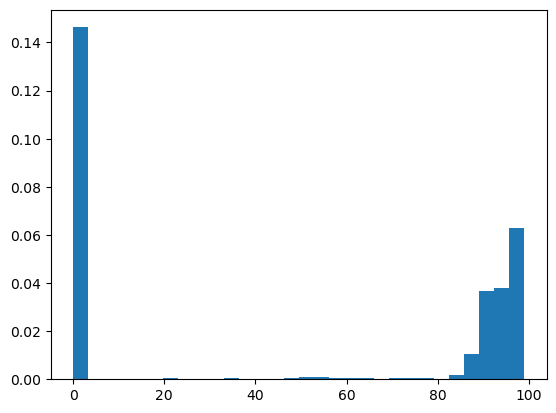

In [20]:
where = np.where(deltas_samples == 1)[0]
plt.hist(where, bins = 30, density=True);

In [21]:
deltas_samples

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

## Find Bayes estimator $\hat{\delta}$

In [22]:
# # d_prova = (np.random.uniform(size=(deltas_samples.shape)) < 0.1).astype(int)
# # d_prova[0, :] = 1
# # d_prova[:, ] = np.array(([1] + [0]*24)*4)
# d_prova = np.array([([1] + [0]*19)*2]*2000).reshape(2000, T).T
# d_prova

In [23]:
etas = np.cumsum(deltas_samples, axis=0)
q_matrix = np.zeros(shape=(T, T))
G = etas.shape[1]
for t in range(G):
    q_matrix += (etas[:, t] == etas[:, t][:, None]).astype(int)
q_matrix /= G
q_matrix

array([[1.    , 1.    , 1.    , ..., 0.162 , 0.055 , 0.    ],
       [1.    , 1.    , 1.    , ..., 0.162 , 0.055 , 0.    ],
       [1.    , 1.    , 1.    , ..., 0.162 , 0.055 , 0.    ],
       ...,
       [0.162 , 0.162 , 0.162 , ..., 1.    , 0.88  , 0.8125],
       [0.055 , 0.055 , 0.055 , ..., 0.88  , 1.    , 0.9325],
       [0.    , 0.    , 0.    , ..., 0.8125, 0.9325, 1.    ]])

In [24]:
delta_final = np.array([0]*T)
delta_final[0] = 1
eta_hat = np.cumsum(delta_final)
Index_add, Index_swap = [True, True]
compute_loss = lambda eta, q_matrix: np.sum(np.abs((eta == eta[:, None]).astype(int) - q_matrix))

current_loss = compute_loss(eta_hat, q_matrix)
candidate_indexes = range(1, T)
iteration = 0
pbar = tqdm(total=100, desc='Loading...', colour='green')

while(Index_add or Index_swap):
    iteration += 1
    # print(f'loss at iteration = {iteration}: {current_loss}')
    all_loss = []
    candidate_indexes = range(1, T)
    for i in candidate_indexes:
        delta_candidate = np.copy(delta_final)
        # Propose a transition:
        delta_candidate[i] = 1 - delta_candidate[i]
        eta_candidate = np.cumsum(delta_candidate)
        candidate_loss = compute_loss(eta_candidate, q_matrix)
        all_loss.append(candidate_loss)
    if min(all_loss) < current_loss:
        # better delta found: add transition
        current_loss = min(all_loss)
        best_index = candidate_indexes[np.argmin(all_loss)]
        delta_final[best_index] = 1 - delta_final[best_index]
        Index_add = True
    else:
        Index_add = False
    
    if np.sum(delta_final, dtype=int) in range(2, T):
        all_loss = []
        candidate_indexes = np.where((delta_final[1:T-1] - delta_final[2:T]) != 0)[0] + 1
        # print(candidate_indexes)
        for i in candidate_indexes:
            delta_candidate = np.copy(delta_final)
            # try different swaps
            mask = np.array([0, 1]) + i
            delta_candidate[mask] = 1 - delta_candidate[mask]

            eta_candidate = np.cumsum(delta_candidate)
            candidate_loss = compute_loss(eta_candidate, q_matrix)
            all_loss.append(candidate_loss)
        if min(all_loss) < current_loss:
            # better delta found: apply swap
            current_loss = min(all_loss)
            best_index = candidate_indexes[np.argmin(all_loss)]
            best_index = np.array([0, 1]) + best_index
            delta_final[best_index] = 1 - delta_final[best_index]
            Index_swap = True
        else:
            Index_swap = False
    pbar.update(1)
    if iteration > 100:
        # max iteration reached
        Index_add, Index_swap = [False, False]
pbar.close()
print(delta_final)
np.where(delta_final == 1)

Loading...:   0%|          | 0/100 [00:00<?, ?it/s]

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


(array([ 0, 95], dtype=int64),)